In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2014-09-19,92.70,99.70,89.95,93.89,271831625,0
1,2014-09-22,92.70,92.95,89.50,89.89,66628862,0
2,2014-09-23,89.00,90.48,86.62,87.17,38984872,0
3,2014-09-24,88.47,90.57,87.22,90.57,32016559,0
4,2014-09-25,91.09,91.50,88.50,88.92,28584828,0


**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

**Feature extraction**

In [4]:
def create_features(ticker,trading_window=5,keep_sample=False):
    #Function to calculate useful statistics from raw data
    #Trading window in working days
    
    import numpy as np
    
    raw_data = pd.read_csv('Stocks/' + ticker + '.txt')
    raw_data.set_index('Date',inplace = True)
    
    features = pd.DataFrame(index=raw_data.index)
    
    features['Open'] = raw_data['Open']
    
    #Close std
    features['std_21_d'] = raw_data['Close'].shift(1).rolling(21).std()
    features['std_tw'] = raw_data['Close'].shift(1).rolling(trading_window).std()
    features['std_4tw'] = raw_data['Close'].shift(1).rolling(4*trading_window).std()
    
    #Overnight pct (Open_t - Close_t-1)
    features['pct_overnight'] = raw_data['Open'].div(raw_data['Close'].shift(1)) - 1
    
    #Close pct (Close - Close) & Close - Close std
    features['pct_close'] = raw_data['Close'].shift(1).div(raw_data['Close'].shift(2)) - 1
    features['pct_close_sigma_21'] = features['pct_close'].div(features['pct_close'].rolling(21).std())
    features['pct_close_sigma_tw'] = features['pct_close'].div(features['pct_close'].rolling(trading_window).std())
    features['pct_close_sigma_4tw'] = features['pct_close'].div(features['pct_close'].rolling(4*trading_window).std())
    
    #Average close return (Momentum)
    features['avg_return_21'] = features['pct_close'].rolling(21).mean()
    features['avg_return_tw'] = features['pct_close'].rolling(trading_window).mean()
    features['avg_return_4tw'] = features['pct_close'].rolling(4*trading_window).mean()
    
    #Open percentile
    def rank(array):
        s = pd.Series(array)
        return s.rank(ascending=True,pct=True)[len(s)-1]
    features['perctentile_tw'] = features['Open'].rolling(trading_window).apply(rank,raw=False)
    features['perctentile_4tw'] = features['Open'].rolling(4*trading_window).apply(rank,raw=False)
    
    #Volume
    features['pct_volume'] = raw_data['Volume'].shift(1).div(raw_data['Volume'].shift(2)) - 1
    features['pct_volume_sigma_21'] = features['pct_volume'].div(features['pct_volume'].rolling(21).std())
    features['pct_volume_sigma_tw'] = features['pct_volume'].div(features['pct_volume'].rolling(trading_window).std())
    features['pct_volume_sigma_4tw'] = features['pct_volume'].div(features['pct_volume'].rolling(4*trading_window).std())
    
    features.drop('pct_volume',axis=1,inplace = True)
    
    #Remove rows with na features
    features.dropna(inplace=True)
    
    #Keep random sample of size trading_window  
    if keep_sample:
        i = np.random.randint(0,high=len(features)-trading_window-1)
        features = features.iloc[i:i+trading_window,]
    
    prices= raw_data.loc[features.index,]
    
    return features, prices

In [5]:
features, prices = create_features('baba.us',5,True)

**Reinforcement Learning**

In [6]:
import gym
import gym_market
import numpy as np

kwargs = {'pos_limit': 2,
                  'trading_window': 21,
                  'trading_freq': 1,
                  'ticker': 'ba.us'}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


/Users/gkonstantellos/opt/miniconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test environment:

In [7]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [0, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0]
Rewards: [1000.0, 980.6921377730506, 937.126770175738, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1206.5371252091109, 857.2073524669461, 1167.489398716973, 1000.0, 1067.1520342612419, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000.0]
Return: 1.184232176979965


In [8]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

***Training:***

Neural net architecture:

In [9]:
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior() 

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
        #with tf.compat.v1.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [10]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [11]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200                # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [12]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.


Populate memory:

In [13]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [14]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: 21182.89307586771 Training loss: 966022.3125 Explore P: 0.9979 Total return: 0.87
Episode: 2 Total reward: 20949.02987624342 Training loss: 986555.3750 Explore P: 0.9959 Total return: 0.92
Episode: 3 Total reward: 20952.262201546793 Training loss: 1032577.8750 Explore P: 0.9938 Total return: 0.94
Episode: 4 Total reward: 21182.84962487276 Training loss: 1047513.8125 Explore P: 0.9917 Total return: 1.13
Episode: 5 Total reward: 20947.71655971336 Training loss: 1016611.8125 Explore P: 0.9897 Total return: 0.80
Episode: 6 Total reward: 20784.9626020216 Training loss: 1008853.1875 Explore P: 0.9876 Total return: 0.72
Episode: 7 Total reward: 20922.05783667736 Training loss: 949320.5000 Explore P: 0.9856 Total return: 0.92
Episode: 8 Total reward: 21149.505148668803 Training loss: 999306.3125 Explore P: 0.9835 Total return: 1.15
Episode: 9 Total reward: 21014.95971062036 Training loss: 976219.3750 Explore P: 0.9815 Total return: 0.94
Episode: 10 Total reward: 21030.

Episode: 81 Total reward: 20942.575796180976 Training loss: 1277194.7500 Explore P: 0.8451 Total return: 0.91
Episode: 82 Total reward: 20979.233716036037 Training loss: 1199771.6250 Explore P: 0.8434 Total return: 0.94
Episode: 83 Total reward: 21029.91778361055 Training loss: 1077439.8750 Explore P: 0.8416 Total return: 1.03
Episode: 84 Total reward: 21097.769670094993 Training loss: 1058366.0000 Explore P: 0.8399 Total return: 1.08
Episode: 85 Total reward: 21067.39889340599 Training loss: 1166642.2500 Explore P: 0.8382 Total return: 1.00
Episode: 86 Total reward: 21093.71043155884 Training loss: 1153679.3750 Explore P: 0.8364 Total return: 1.04
Episode: 87 Total reward: 20977.316798164422 Training loss: 2554861.7500 Explore P: 0.8347 Total return: 0.95
Episode: 88 Total reward: 21296.663536521664 Training loss: 1049650.7500 Explore P: 0.8330 Total return: 1.31
Episode: 89 Total reward: 21243.420566109497 Training loss: 1056396.7500 Explore P: 0.8312 Total return: 1.08
Episode: 90 T

Episode: 159 Total reward: 20928.533604103515 Training loss: 2300000.0000 Explore P: 0.7190 Total return: 0.81
Episode: 160 Total reward: 21049.086188813577 Training loss: 2107386.7500 Explore P: 0.7175 Total return: 0.91
Episode: 161 Total reward: 20598.274578396387 Training loss: 1665543.7500 Explore P: 0.7160 Total return: 0.53
Episode: 162 Total reward: 21115.807714697705 Training loss: 1765181.7500 Explore P: 0.7145 Total return: 1.12
Episode: 163 Total reward: 20998.082087276132 Training loss: 1988464.7500 Explore P: 0.7130 Total return: 0.99
Episode: 164 Total reward: 20967.399398220263 Training loss: 1377695.7500 Explore P: 0.7116 Total return: 0.94
Episode: 165 Total reward: 21194.893136443934 Training loss: 1660262.0000 Explore P: 0.7101 Total return: 1.18
Episode: 166 Total reward: 20975.28938798226 Training loss: 4382897.5000 Explore P: 0.7086 Total return: 0.84
Episode: 167 Total reward: 21075.39696039858 Training loss: 3599833.5000 Explore P: 0.7072 Total return: 1.06
Epi

Episode: 234 Total reward: 20762.92973512895 Training loss: 1411819.1250 Explore P: 0.6157 Total return: 0.78
Episode: 235 Total reward: 20875.702789589322 Training loss: 2087622.6250 Explore P: 0.6144 Total return: 0.87
Episode: 236 Total reward: 20759.617714559055 Training loss: 2110667.5000 Explore P: 0.6131 Total return: 0.73
Episode: 237 Total reward: 20953.269535114156 Training loss: 3168316.0000 Explore P: 0.6118 Total return: 0.83
Episode: 238 Total reward: 21136.544809228133 Training loss: 10138022.0000 Explore P: 0.6106 Total return: 1.11
Episode: 239 Total reward: 20874.52128876254 Training loss: 1594690.7500 Explore P: 0.6093 Total return: 0.79
Episode: 240 Total reward: 20998.024242812375 Training loss: 2727588.7500 Explore P: 0.6081 Total return: 0.97
Episode: 241 Total reward: 21114.588858989002 Training loss: 2044919.6250 Explore P: 0.6068 Total return: 1.09
Episode: 242 Total reward: 20906.721599012977 Training loss: 2423222.2500 Explore P: 0.6056 Total return: 0.43
Ep

Episode: 311 Total reward: 20887.29196121844 Training loss: 24407262.0000 Explore P: 0.5252 Total return: 0.81
Episode: 312 Total reward: 20987.218205734418 Training loss: 212266352.0000 Explore P: 0.5241 Total return: 0.96
Episode: 313 Total reward: 21094.460566586014 Training loss: 2232207.2500 Explore P: 0.5231 Total return: 1.08
Episode: 314 Total reward: 21057.24753477461 Training loss: 216435680.0000 Explore P: 0.5220 Total return: 1.04
Episode: 315 Total reward: 20941.62436532106 Training loss: 4527558.5000 Explore P: 0.5209 Total return: 0.93
Episode: 316 Total reward: 21241.078010725 Training loss: 1868316.6250 Explore P: 0.5198 Total return: 1.24
Episode: 317 Total reward: 20973.69764248407 Training loss: 1605331.2500 Explore P: 0.5188 Total return: 0.97
Episode: 318 Total reward: 21034.812340007164 Training loss: 1910777.2500 Explore P: 0.5177 Total return: 1.02
Episode: 319 Total reward: 20994.492222264 Training loss: 8194112.0000 Explore P: 0.5166 Total return: 0.99
Episod

Episode: 386 Total reward: 20892.943250107855 Training loss: 3489320.0000 Explore P: 0.4501 Total return: 0.89
Episode: 387 Total reward: 20912.96230134723 Training loss: 4112818.0000 Explore P: 0.4492 Total return: 0.92
Episode: 388 Total reward: 20941.192511832403 Training loss: 3475107.5000 Explore P: 0.4483 Total return: 0.94
Episode: 389 Total reward: 21048.602336938497 Training loss: 5610773.0000 Explore P: 0.4474 Total return: 0.34
Episode: 390 Total reward: 21147.012932108144 Training loss: 2976685.2500 Explore P: 0.4465 Total return: 1.15
Episode: 391 Total reward: 20992.92931839537 Training loss: 26619670.0000 Explore P: 0.4455 Total return: 0.97
Episode: 392 Total reward: 20843.692902315393 Training loss: 2324603.0000 Explore P: 0.4446 Total return: 0.80
Episode: 393 Total reward: 20963.133797470105 Training loss: 1867127.0000 Explore P: 0.4437 Total return: 0.94
Episode: 394 Total reward: 21231.63404184249 Training loss: 2332310.5000 Explore P: 0.4428 Total return: 1.24
Epi

Episode: 461 Total reward: 21069.667739708973 Training loss: 2372432.7500 Explore P: 0.3860 Total return: 1.03
Episode: 462 Total reward: 20926.295725828146 Training loss: 3738436.7500 Explore P: 0.3852 Total return: 0.91
Episode: 463 Total reward: 21040.974651179902 Training loss: 3132862.0000 Explore P: 0.3844 Total return: 1.04
Episode: 464 Total reward: 21083.317317428096 Training loss: 4666989.5000 Explore P: 0.3836 Total return: 1.08
Episode: 465 Total reward: 20935.164158987776 Training loss: 3936178.5000 Explore P: 0.3829 Total return: 0.89
Episode: 466 Total reward: 21262.254348786693 Training loss: 4601566.0000 Explore P: 0.3821 Total return: 1.28
Episode: 467 Total reward: 21047.34823443605 Training loss: 22724270.0000 Explore P: 0.3813 Total return: 1.04
Episode: 468 Total reward: 20926.92924308628 Training loss: 21170444.0000 Explore P: 0.3805 Total return: 0.93
Episode: 469 Total reward: 20996.36446870229 Training loss: 1936726.2500 Explore P: 0.3797 Total return: 1.00
Ep

Episode: 538 Total reward: 21150.224971382006 Training loss: 8075697.5000 Explore P: 0.3299 Total return: 1.16
Episode: 539 Total reward: 21019.898751913497 Training loss: 4574362.5000 Explore P: 0.3292 Total return: 1.02
Episode: 540 Total reward: 20855.60937778372 Training loss: 11843517.0000 Explore P: 0.3285 Total return: 0.85
Episode: 541 Total reward: 21113.489815942346 Training loss: 7068793.0000 Explore P: 0.3279 Total return: 1.10
Episode: 542 Total reward: 21008.122117707586 Training loss: 14238832.0000 Explore P: 0.3272 Total return: 1.01
Episode: 543 Total reward: 20765.10753430946 Training loss: 3676373.5000 Explore P: 0.3265 Total return: 0.78
Episode: 544 Total reward: 21432.407416992708 Training loss: 327258368.0000 Explore P: 0.3259 Total return: 1.48
Episode: 545 Total reward: 20878.714091122714 Training loss: 4937753.0000 Explore P: 0.3252 Total return: 0.87
Episode: 546 Total reward: 20900.017538371732 Training loss: 2350076.5000 Explore P: 0.3245 Total return: 0.90

Episode: 614 Total reward: 21006.639426187958 Training loss: 6508924.5000 Explore P: 0.2827 Total return: 0.87
Episode: 615 Total reward: 21081.301887727805 Training loss: 8495330.0000 Explore P: 0.2821 Total return: 1.05
Episode: 616 Total reward: 21010.894496294488 Training loss: 1617953.0000 Explore P: 0.2815 Total return: 1.00
Episode: 617 Total reward: 20694.539013014815 Training loss: 2586325.5000 Explore P: 0.2810 Total return: 0.68
Episode: 618 Total reward: 20858.620698807765 Training loss: 10480686.0000 Explore P: 0.2804 Total return: 0.85
Episode: 619 Total reward: 20975.42152063174 Training loss: 9611119.0000 Explore P: 0.2798 Total return: 0.98
Episode: 620 Total reward: 20920.49533198375 Training loss: 1889687.6250 Explore P: 0.2793 Total return: 0.92
Episode: 621 Total reward: 21143.69378503158 Training loss: 2586112.7500 Explore P: 0.2787 Total return: 1.15
Episode: 622 Total reward: 20913.61649132272 Training loss: 1777285.3750 Explore P: 0.2781 Total return: 0.90
Epis

Episode: 692 Total reward: 21003.76601375964 Training loss: 3019575.5000 Explore P: 0.2415 Total return: 1.00
Episode: 693 Total reward: 21069.574124572348 Training loss: 996057.5000 Explore P: 0.2410 Total return: 1.07
Episode: 694 Total reward: 21028.66483645719 Training loss: 4166107.5000 Explore P: 0.2405 Total return: 1.02
Episode: 695 Total reward: 20916.100357673135 Training loss: 17765148.0000 Explore P: 0.2400 Total return: 0.92
Episode: 696 Total reward: 20963.287156469483 Training loss: 1994290.7500 Explore P: 0.2395 Total return: 0.96
Episode: 697 Total reward: 20783.20658841286 Training loss: 4090408.7500 Explore P: 0.2391 Total return: 0.78
Episode: 698 Total reward: 21052.2850007123 Training loss: 1827366.0000 Explore P: 0.2386 Total return: 1.04
Episode: 699 Total reward: 20987.23091892618 Training loss: 90442928.0000 Explore P: 0.2381 Total return: 0.99
Episode: 700 Total reward: 21045.61855086676 Training loss: 158063984.0000 Explore P: 0.2376 Total return: 1.03
Episo

Episode: 768 Total reward: 21208.95488884776 Training loss: 3944581.2500 Explore P: 0.2073 Total return: 1.04
Episode: 769 Total reward: 20962.17769010814 Training loss: 1918425.6250 Explore P: 0.2069 Total return: 0.96
Episode: 770 Total reward: 21072.683312157656 Training loss: 85531672.0000 Explore P: 0.2065 Total return: 1.07
Episode: 771 Total reward: 20836.461929374185 Training loss: 10675592.0000 Explore P: 0.2061 Total return: 0.83
Episode: 772 Total reward: 21093.44062938584 Training loss: 2017124.3750 Explore P: 0.2057 Total return: 1.10
Episode: 773 Total reward: 21207.16847884422 Training loss: 4946354.5000 Explore P: 0.2053 Total return: 1.21
Episode: 774 Total reward: 20973.30583830585 Training loss: 1868024.7500 Explore P: 0.2049 Total return: 0.97
Episode: 775 Total reward: 20948.458630404133 Training loss: 2435232.7500 Explore P: 0.2045 Total return: 0.93
Episode: 776 Total reward: 21084.24235924708 Training loss: 1779241.6250 Explore P: 0.2040 Total return: 1.09
Episo

Episode: 846 Total reward: 21186.06625642861 Training loss: 2456820.5000 Explore P: 0.1775 Total return: 1.13
Episode: 847 Total reward: 20901.455812999797 Training loss: 7286363.0000 Explore P: 0.1772 Total return: 0.90
Episode: 848 Total reward: 20817.370844706187 Training loss: 2816318.7500 Explore P: 0.1768 Total return: 0.83
Episode: 849 Total reward: 21225.089117066556 Training loss: 2449549.7500 Explore P: 0.1765 Total return: 1.23
Episode: 850 Total reward: 20823.33253769988 Training loss: 3662780.7500 Explore P: 0.1761 Total return: 0.83
Episode: 851 Total reward: 20936.300446104367 Training loss: 8977298.0000 Explore P: 0.1758 Total return: 0.94
Episode: 852 Total reward: 21042.710784795214 Training loss: 2155069.2500 Explore P: 0.1754 Total return: 1.04
Episode: 853 Total reward: 21077.651232787644 Training loss: 1940437.2500 Explore P: 0.1751 Total return: 1.08
Episode: 854 Total reward: 21142.60650024102 Training loss: 2420261.2500 Explore P: 0.1747 Total return: 1.15
Epis

Episode: 923 Total reward: 21033.552199777238 Training loss: 1664019.3750 Explore P: 0.1525 Total return: 1.03
Episode: 924 Total reward: 20914.18066685845 Training loss: 17414116.0000 Explore P: 0.1522 Total return: 0.92
Episode: 925 Total reward: 21140.833595155753 Training loss: 1604444.3750 Explore P: 0.1519 Total return: 0.86
Episode: 926 Total reward: 20828.07834304237 Training loss: 1544799.7500 Explore P: 0.1516 Total return: 0.84
Episode: 927 Total reward: 21075.376715281393 Training loss: 1431341.3750 Explore P: 0.1513 Total return: 1.08
Episode: 928 Total reward: 21079.83863138462 Training loss: 11788570.0000 Explore P: 0.1510 Total return: 1.06
Episode: 929 Total reward: 21130.94730838351 Training loss: 1836836.6250 Explore P: 0.1507 Total return: 1.05
Episode: 930 Total reward: 21054.96109851372 Training loss: 1288045.6250 Explore P: 0.1504 Total return: 1.05
Episode: 931 Total reward: 20901.861044251604 Training loss: 1794249.2500 Explore P: 0.1501 Total return: 0.91
Epis

Episode: 998 Total reward: 21109.750305124384 Training loss: 75305208.0000 Explore P: 0.1317 Total return: 1.11
Episode: 999 Total reward: 21079.239764154096 Training loss: 5512158.0000 Explore P: 0.1315 Total return: 1.07
Episode: 1000 Total reward: 20827.09283397082 Training loss: 4207775.0000 Explore P: 0.1312 Total return: 0.83
Episode: 1001 Total reward: 20972.282682144407 Training loss: 3397238.7500 Explore P: 0.1310 Total return: 0.97
Episode: 1002 Total reward: 21078.642432317705 Training loss: 13257597.0000 Explore P: 0.1307 Total return: 1.08
Episode: 1003 Total reward: 20828.90644868056 Training loss: 6262568.5000 Explore P: 0.1305 Total return: 0.84
Episode: 1004 Total reward: 21270.87904620027 Training loss: 49901496.0000 Explore P: 0.1302 Total return: 1.29
Episode: 1005 Total reward: 20981.215632255822 Training loss: 1742801.6250 Explore P: 0.1300 Total return: 0.98
Episode: 1006 Total reward: 21003.988626310962 Training loss: 1573097.8750 Explore P: 0.1297 Total return:

Episode: 1075 Total reward: 21039.784589106093 Training loss: 1604757.2500 Explore P: 0.1136 Total return: 1.04
Episode: 1076 Total reward: 21000.0 Training loss: 45554328.0000 Explore P: 0.1133 Total return: 1.00
Episode: 1077 Total reward: 21076.569290162 Training loss: 19268322.0000 Explore P: 0.1131 Total return: 1.08
Episode: 1078 Total reward: 20928.452360003932 Training loss: 17798762.0000 Explore P: 0.1129 Total return: 0.93
Episode: 1079 Total reward: 20962.241769063767 Training loss: 6221260.5000 Explore P: 0.1127 Total return: 0.96
Episode: 1080 Total reward: 21086.684553880063 Training loss: 44301404.0000 Explore P: 0.1125 Total return: 1.09
Episode: 1081 Total reward: 21187.635822815584 Training loss: 1599031.2500 Explore P: 0.1123 Total return: 1.19
Episode: 1082 Total reward: 21151.53694049973 Training loss: 11867505.0000 Explore P: 0.1121 Total return: 1.16
Episode: 1083 Total reward: 21085.084418795574 Training loss: 3706851.5000 Explore P: 0.1118 Total return: 1.08
Ep

Episode: 1151 Total reward: 21281.146573786726 Training loss: 1965831.2500 Explore P: 0.0983 Total return: 1.30
Episode: 1152 Total reward: 21135.081373198864 Training loss: 15184237.0000 Explore P: 0.0981 Total return: 1.14
Episode: 1153 Total reward: 20895.563770794826 Training loss: 1559849.6250 Explore P: 0.0979 Total return: 0.90
Episode: 1154 Total reward: 21180.51292640939 Training loss: 2309799.2500 Explore P: 0.0977 Total return: 1.19
Episode: 1155 Total reward: 21150.81738575627 Training loss: 5945444.0000 Explore P: 0.0975 Total return: 1.15
Episode: 1156 Total reward: 20966.57686622531 Training loss: 1750846.0000 Explore P: 0.0974 Total return: 0.97
Episode: 1157 Total reward: 21066.90707195294 Training loss: 5047583.0000 Explore P: 0.0972 Total return: 1.06
Episode: 1158 Total reward: 21367.541057058945 Training loss: 8017331.0000 Explore P: 0.0970 Total return: 1.41
Episode: 1159 Total reward: 21089.106813801285 Training loss: 3217558.0000 Explore P: 0.0968 Total return: 

Episode: 1228 Total reward: 21000.0 Training loss: 3358774.5000 Explore P: 0.0851 Total return: 1.00
Episode: 1229 Total reward: 21017.617601630547 Training loss: 9542057.0000 Explore P: 0.0849 Total return: 1.02
Episode: 1230 Total reward: 21000.0 Training loss: 17276000.0000 Explore P: 0.0848 Total return: 1.00
Episode: 1231 Total reward: 21007.48142454522 Training loss: 1510057.7500 Explore P: 0.0846 Total return: 1.01
Episode: 1232 Total reward: 21038.589029958097 Training loss: 13137883.0000 Explore P: 0.0845 Total return: 1.04
Episode: 1233 Total reward: 21009.714368566045 Training loss: 6218345.5000 Explore P: 0.0843 Total return: 1.01
Episode: 1234 Total reward: 21049.469887894324 Training loss: 5018604.0000 Explore P: 0.0842 Total return: 1.05
Episode: 1235 Total reward: 20992.938607697848 Training loss: 1718200.3750 Explore P: 0.0840 Total return: 0.99
Episode: 1236 Total reward: 20865.672626325675 Training loss: 1499341.3750 Explore P: 0.0839 Total return: 0.87
Episode: 1237

Episode: 1304 Total reward: 21000.0 Training loss: 1837629.6250 Explore P: 0.0740 Total return: 1.00
Episode: 1305 Total reward: 21000.0 Training loss: 8245672.0000 Explore P: 0.0739 Total return: 1.00
Episode: 1306 Total reward: 21043.69229131742 Training loss: 1541010.7500 Explore P: 0.0738 Total return: 1.04
Episode: 1307 Total reward: 20932.56758094861 Training loss: 60613768.0000 Explore P: 0.0736 Total return: 0.93
Episode: 1308 Total reward: 21000.0 Training loss: 17524094.0000 Explore P: 0.0735 Total return: 1.00
Episode: 1309 Total reward: 20881.482885844853 Training loss: 74407992.0000 Explore P: 0.0734 Total return: 0.88
Episode: 1310 Total reward: 20980.783946943287 Training loss: 25634336.0000 Explore P: 0.0732 Total return: 0.98
Episode: 1311 Total reward: 20911.915600838212 Training loss: 1874125.6250 Explore P: 0.0731 Total return: 0.91
Episode: 1312 Total reward: 21067.77441780715 Training loss: 8289830.5000 Explore P: 0.0730 Total return: 1.07
Episode: 1313 Total rewa

Episode: 1384 Total reward: 20986.454771005163 Training loss: 1857244.0000 Explore P: 0.0641 Total return: 0.99
Episode: 1385 Total reward: 21102.36475142256 Training loss: 2902097.5000 Explore P: 0.0640 Total return: 1.10
Episode: 1386 Total reward: 20940.52106013965 Training loss: 3563544.0000 Explore P: 0.0639 Total return: 0.94
Episode: 1387 Total reward: 21013.84618183803 Training loss: 1393727.5000 Explore P: 0.0638 Total return: 1.01
Episode: 1388 Total reward: 21029.971419682035 Training loss: 3029423.7500 Explore P: 0.0637 Total return: 1.03
Episode: 1389 Total reward: 21000.0 Training loss: 3739800.7500 Explore P: 0.0636 Total return: 1.00
Episode: 1390 Total reward: 20989.99828542036 Training loss: 8691232.0000 Explore P: 0.0634 Total return: 0.99
Episode: 1391 Total reward: 21063.702359346644 Training loss: 2167008.5000 Explore P: 0.0633 Total return: 1.06
Episode: 1392 Total reward: 21054.78152094207 Training loss: 4354081.5000 Explore P: 0.0632 Total return: 1.05
Episode:

Episode: 1464 Total reward: 21000.0 Training loss: 1749758.0000 Explore P: 0.0558 Total return: 1.00
Episode: 1465 Total reward: 21000.0 Training loss: 1450560.2500 Explore P: 0.0557 Total return: 1.00
Episode: 1466 Total reward: 21002.248798936933 Training loss: 3577298.7500 Explore P: 0.0556 Total return: 1.00
Episode: 1467 Total reward: 21000.0 Training loss: 39788932.0000 Explore P: 0.0555 Total return: 1.00
Episode: 1468 Total reward: 21000.0 Training loss: 1169347.5000 Explore P: 0.0554 Total return: 1.00
Episode: 1469 Total reward: 21000.0 Training loss: 1609537.5000 Explore P: 0.0553 Total return: 1.00
Episode: 1470 Total reward: 20973.180667141824 Training loss: 1926860.0000 Explore P: 0.0552 Total return: 0.97
Episode: 1471 Total reward: 21000.0 Training loss: 56400392.0000 Explore P: 0.0551 Total return: 1.00
Episode: 1472 Total reward: 20930.883412018884 Training loss: 149560960.0000 Explore P: 0.0550 Total return: 0.93
Episode: 1473 Total reward: 21000.0 Training loss: 324

Episode: 1544 Total reward: 21000.0 Training loss: 4198867.5000 Explore P: 0.0487 Total return: 1.00
Episode: 1545 Total reward: 21000.0 Training loss: 4570165.0000 Explore P: 0.0486 Total return: 1.00
Episode: 1546 Total reward: 21000.0 Training loss: 1224396.8750 Explore P: 0.0485 Total return: 1.00
Episode: 1547 Total reward: 21000.0 Training loss: 8715280.0000 Explore P: 0.0484 Total return: 1.00
Episode: 1548 Total reward: 21000.0 Training loss: 3216471.5000 Explore P: 0.0484 Total return: 1.00
Episode: 1549 Total reward: 20959.176559392865 Training loss: 7644237.5000 Explore P: 0.0483 Total return: 0.94
Episode: 1550 Total reward: 21000.0 Training loss: 906128.6250 Explore P: 0.0482 Total return: 1.00
Episode: 1551 Total reward: 21000.0 Training loss: 2561835.0000 Explore P: 0.0481 Total return: 1.00
Episode: 1552 Total reward: 21044.445331514013 Training loss: 1585892.6250 Explore P: 0.0480 Total return: 1.04
Episode: 1553 Total reward: 21000.0 Training loss: 1192993.0000 Explor

Episode: 1624 Total reward: 20971.146696650405 Training loss: 29537428.0000 Explore P: 0.0427 Total return: 0.97
Episode: 1625 Total reward: 21000.0 Training loss: 10215686.0000 Explore P: 0.0426 Total return: 1.00
Episode: 1626 Total reward: 21000.0 Training loss: 38058664.0000 Explore P: 0.0426 Total return: 1.00
Episode: 1627 Total reward: 20993.655611218783 Training loss: 17516444.0000 Explore P: 0.0425 Total return: 0.99
Episode: 1628 Total reward: 21000.0 Training loss: 50653644.0000 Explore P: 0.0424 Total return: 1.00
Episode: 1629 Total reward: 20863.863411273305 Training loss: 1067302.2500 Explore P: 0.0424 Total return: 0.86
Episode: 1630 Total reward: 21000.0 Training loss: 1188709.3750 Explore P: 0.0423 Total return: 1.00
Episode: 1631 Total reward: 20996.308626747374 Training loss: 31929836.0000 Explore P: 0.0422 Total return: 1.00
Episode: 1632 Total reward: 21000.0 Training loss: 1566443.3750 Explore P: 0.0422 Total return: 1.00
Episode: 1633 Total reward: 21013.9512508

Episode: 1704 Total reward: 21000.0 Training loss: 921226.8125 Explore P: 0.0376 Total return: 1.00
Episode: 1705 Total reward: 21000.0 Training loss: 14230360.0000 Explore P: 0.0376 Total return: 1.00
Episode: 1706 Total reward: 21234.63477786863 Training loss: 91532664.0000 Explore P: 0.0375 Total return: 1.23
Episode: 1707 Total reward: 21109.718684342635 Training loss: 822730.3125 Explore P: 0.0375 Total return: 1.11
Episode: 1708 Total reward: 21000.0 Training loss: 1490716.8750 Explore P: 0.0374 Total return: 1.00
Episode: 1709 Total reward: 21077.942374949733 Training loss: 1399000.3750 Explore P: 0.0374 Total return: 1.08
Episode: 1710 Total reward: 21005.551608254274 Training loss: 14021941.0000 Explore P: 0.0373 Total return: 1.01
Episode: 1711 Total reward: 21000.0 Training loss: 1717037.2500 Explore P: 0.0372 Total return: 1.00
Episode: 1712 Total reward: 21000.0 Training loss: 1106270.1250 Explore P: 0.0372 Total return: 1.00
Episode: 1713 Total reward: 21091.236602719986 

Episode: 1785 Total reward: 20868.384074941452 Training loss: 2852236.7500 Explore P: 0.0333 Total return: 0.87
Episode: 1786 Total reward: 21000.0 Training loss: 1305924.2500 Explore P: 0.0333 Total return: 1.00
Episode: 1787 Total reward: 21012.0335313401 Training loss: 1206017.5000 Explore P: 0.0332 Total return: 1.01
Episode: 1788 Total reward: 21000.0 Training loss: 2067686.2500 Explore P: 0.0332 Total return: 1.00
Episode: 1789 Total reward: 21000.0 Training loss: 1864672.7500 Explore P: 0.0331 Total return: 1.00
Episode: 1790 Total reward: 20986.100293571384 Training loss: 5523633.0000 Explore P: 0.0331 Total return: 0.99
Episode: 1791 Total reward: 21056.082436622288 Training loss: 957574.0000 Explore P: 0.0330 Total return: 1.06
Episode: 1792 Total reward: 21018.91051039098 Training loss: 1100058.3750 Explore P: 0.0330 Total return: 1.02
Episode: 1793 Total reward: 21000.0 Training loss: 2535368.0000 Explore P: 0.0329 Total return: 1.00
Episode: 1794 Total reward: 20933.915729

Episode: 1865 Total reward: 20929.416195346515 Training loss: 7420177.0000 Explore P: 0.0297 Total return: 0.93
Episode: 1866 Total reward: 21000.0 Training loss: 1236904.3750 Explore P: 0.0297 Total return: 1.00
Episode: 1867 Total reward: 21000.0 Training loss: 5487642.5000 Explore P: 0.0296 Total return: 1.00
Episode: 1868 Total reward: 21000.0 Training loss: 58991700.0000 Explore P: 0.0296 Total return: 1.00
Episode: 1869 Total reward: 21000.0 Training loss: 911937.3750 Explore P: 0.0295 Total return: 1.00
Episode: 1870 Total reward: 21000.0 Training loss: 810588.3750 Explore P: 0.0295 Total return: 1.00
Episode: 1871 Total reward: 20992.51526492023 Training loss: 1110543.6250 Explore P: 0.0295 Total return: 0.99
Episode: 1872 Total reward: 20983.663943990665 Training loss: 5741357.5000 Explore P: 0.0294 Total return: 0.98
Episode: 1873 Total reward: 21115.568463726024 Training loss: 1691326.7500 Explore P: 0.0294 Total return: 1.12
Episode: 1874 Total reward: 21000.0 Training loss

Episode: 1945 Total reward: 21000.0 Training loss: 722198.6875 Explore P: 0.0267 Total return: 1.00
Episode: 1946 Total reward: 21000.0 Training loss: 1207045.7500 Explore P: 0.0266 Total return: 1.00
Episode: 1947 Total reward: 21055.043661082847 Training loss: 9676479.0000 Explore P: 0.0266 Total return: 1.05
Episode: 1948 Total reward: 20728.30932032072 Training loss: 1072564.1250 Explore P: 0.0266 Total return: 0.69
Episode: 1949 Total reward: 20986.112176659815 Training loss: 1138645.7500 Explore P: 0.0265 Total return: 0.99
Episode: 1950 Total reward: 21022.416463028218 Training loss: 51302488.0000 Explore P: 0.0265 Total return: 1.02
Episode: 1951 Total reward: 21047.48544894341 Training loss: 5612143.5000 Explore P: 0.0265 Total return: 1.05
Episode: 1952 Total reward: 21374.141559966 Training loss: 7753417.5000 Explore P: 0.0264 Total return: 1.41
Episode: 1953 Total reward: 20931.38206123329 Training loss: 12399276.0000 Explore P: 0.0264 Total return: 0.93
Episode: 1954 Total

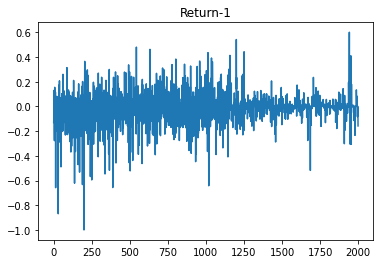

In [15]:
import matplotlib.pyplot as plt
import pandas as pd


x,y = zip(*total_returns_list)
z = [y_i-1 for y_i in y]
z = pd.DataFrame(z)
z = z[z<=25]

plt.plot(x,z)
plt.title('Return-1')
plt.show()

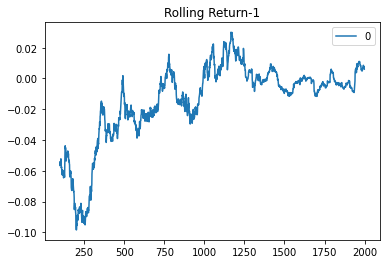

In [16]:
rolling_z = z.rolling(100).mean()
rolling_plot = rolling_z.plot(title='Rolling Return-1')

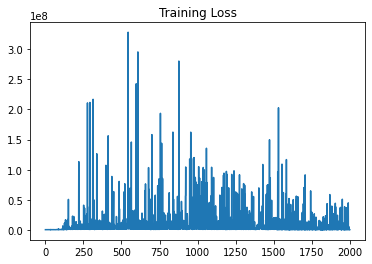

In [17]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

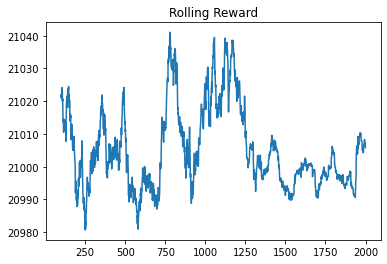

In [18]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
plt.plot(ep[:],reward.rolling(100).mean())
plt.title('Rolling Reward')
plt.show()

Run episode with trained model:

In [35]:
def run_episode(env): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            if done:
                break

    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    
    
    print('Return: {:.5f}'.format(info_log['total_return']))
    
    %matplotlib inline
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(17,4))
    #Plot Prices
    plt.xticks(rotation=90)
    plt.grid(color='k', linestyle='--', linewidth=0.1)
    plt.ylim(min(plt_df.Close)*0.98, max(plt_df.Close)*1.02)
    plt.plot(plt_df.index,plt_df.Close,color='black')
    #Plot Buys
    plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Close,
                color='green',marker='^',s=100,zorder=3)
    #Plot Buys
    plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Close,
                color='red',marker='v',s=100,zorder=3)

    for i, txt in enumerate(plt_df.Trades):
        if txt !=0:
            plt.annotate(txt, (plt_df.index[i], plt_df.Close[i]+0.008*plt_df.Close[i]))
            plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Close[i]-0.015*plt_df.Close[i]))

    plt.show()
    return plt_df

Return: 1.00000


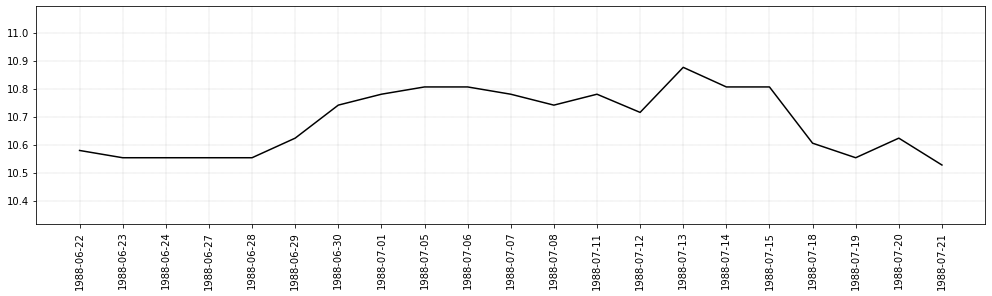

Return: 1.00000


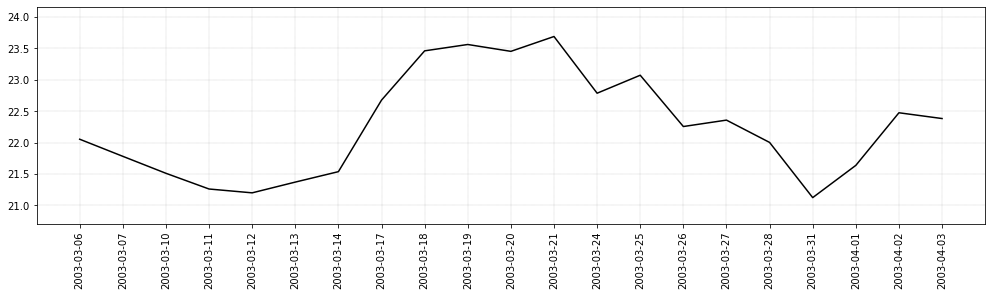

Return: 1.00000


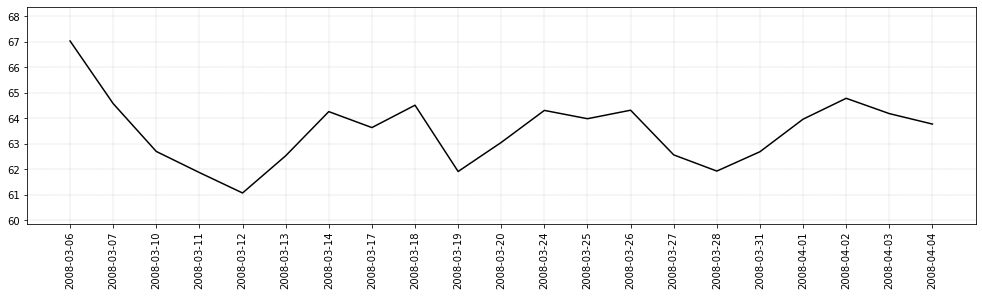

Return: 1.00000


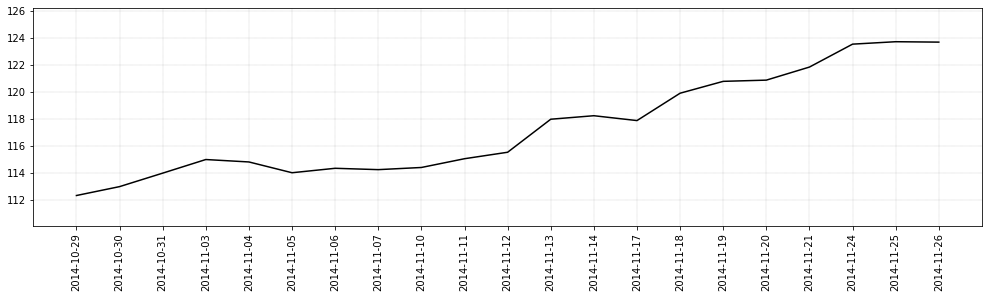

Return: 1.00000


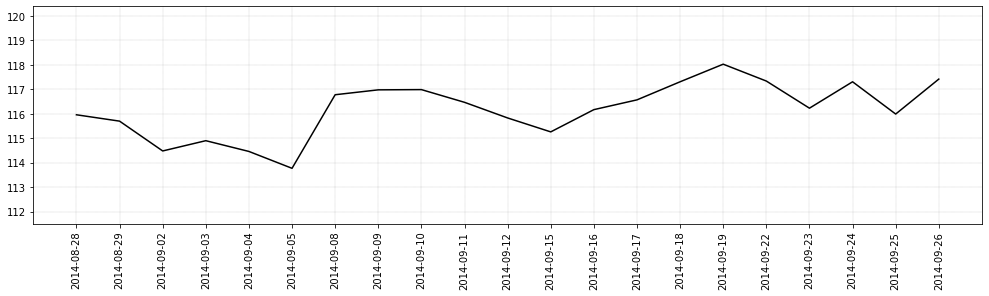

Return: 1.00000


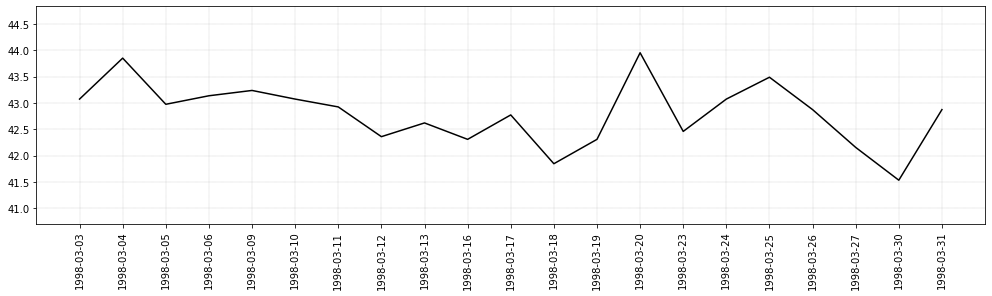

Return: 1.00000


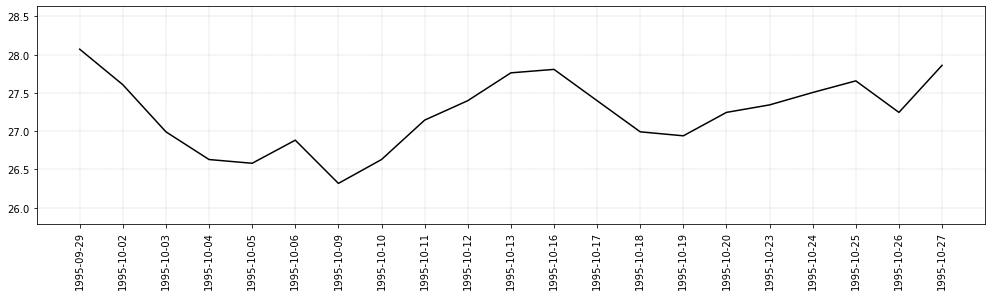

Return: 1.00000


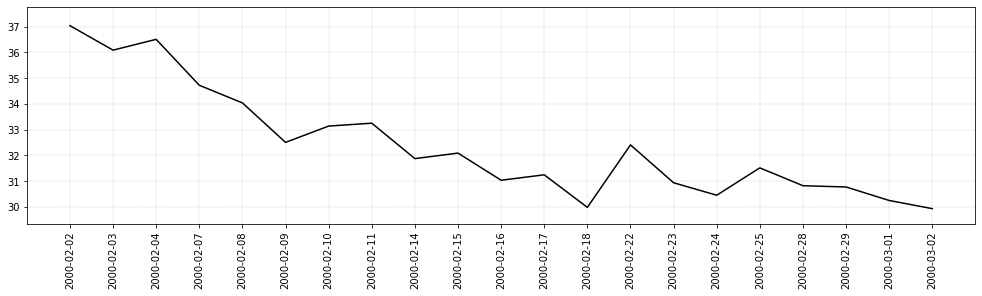

Return: 1.00000


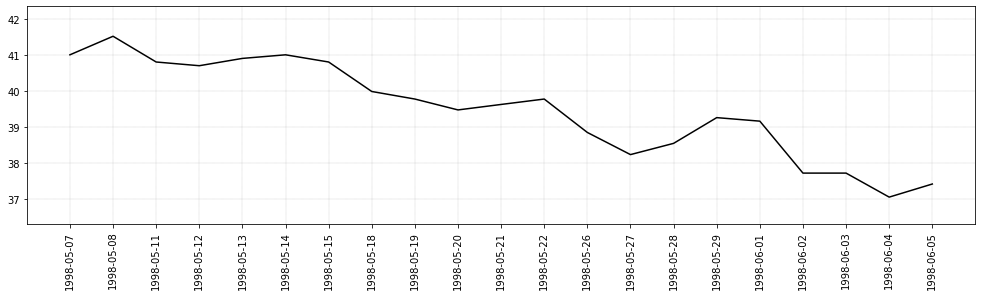

Return: 1.00000


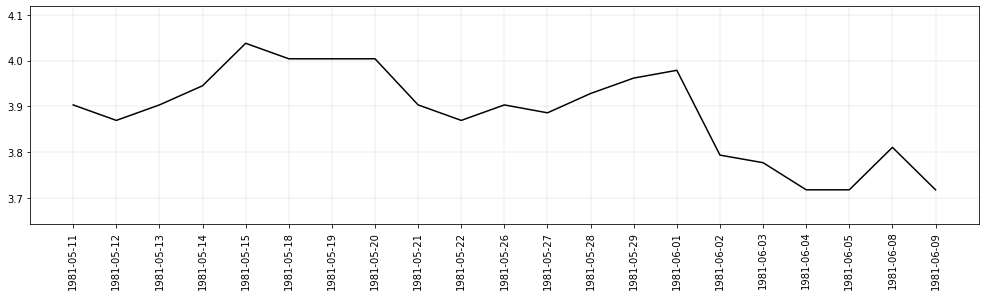

Return: 1.00000


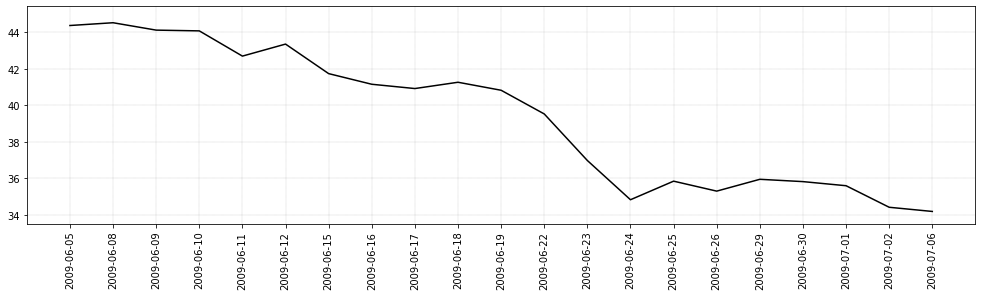

Return: 1.00000


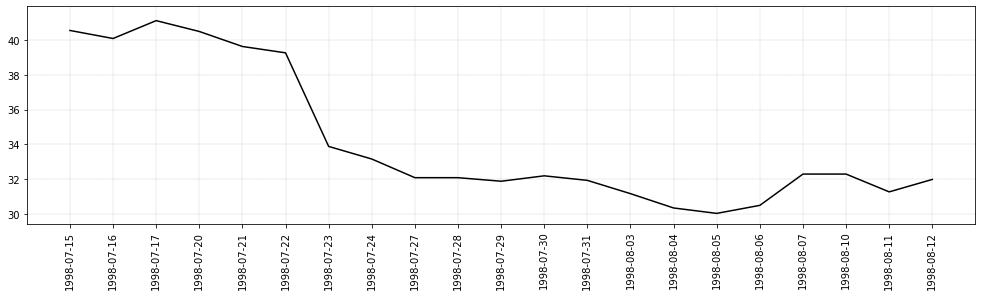

Return: 1.00000


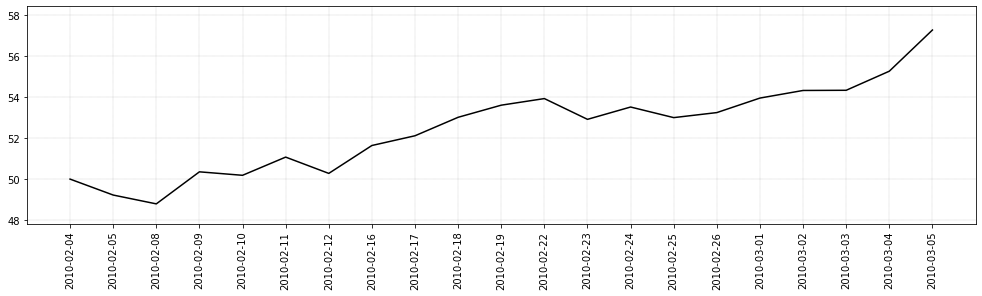

Return: 1.00000


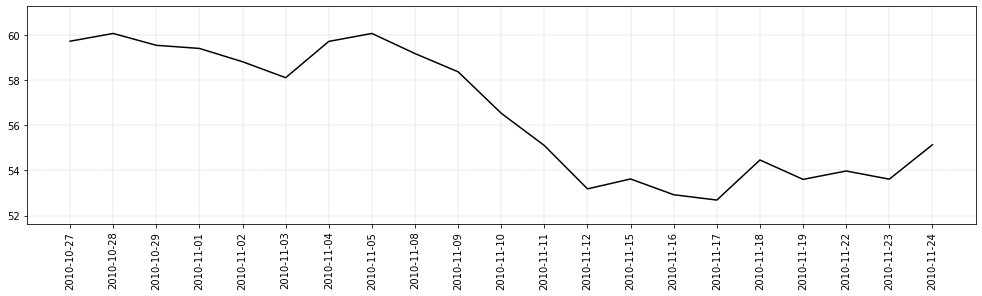

Return: 1.00000


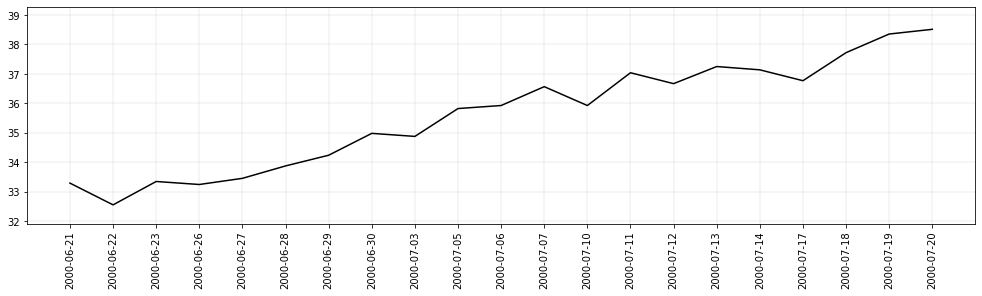

Return: 1.00000


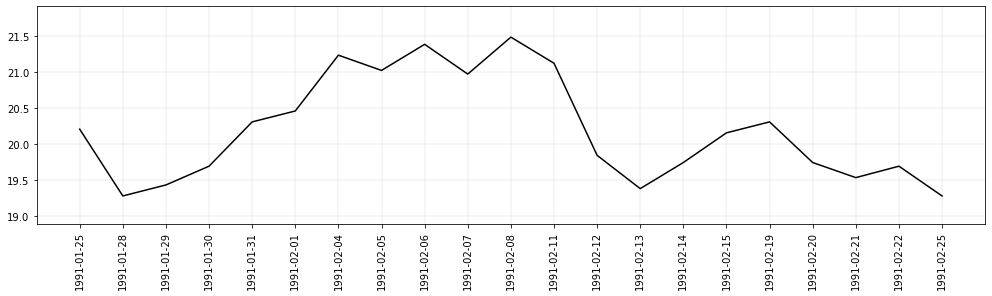

Return: 1.00000


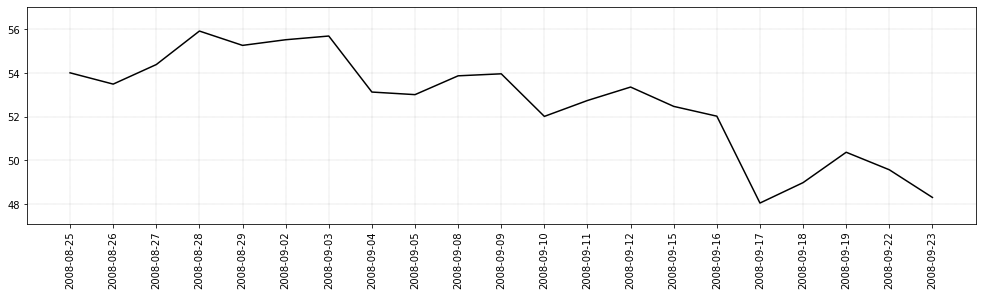

Return: 1.00000


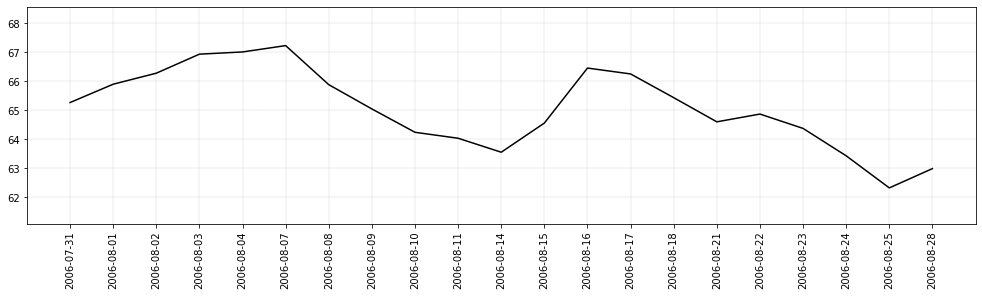

Return: 1.00000


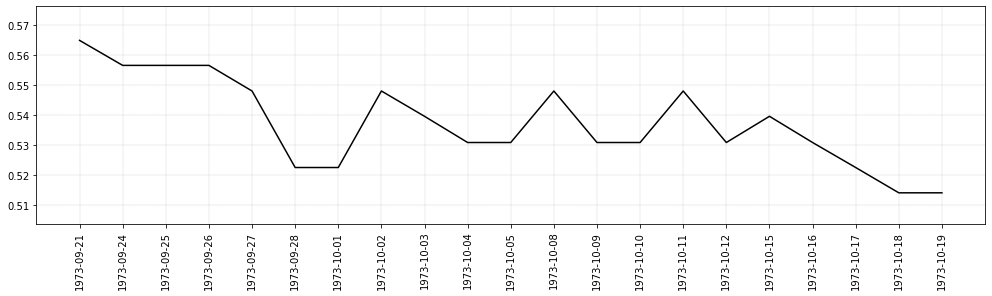

Return: 1.00000


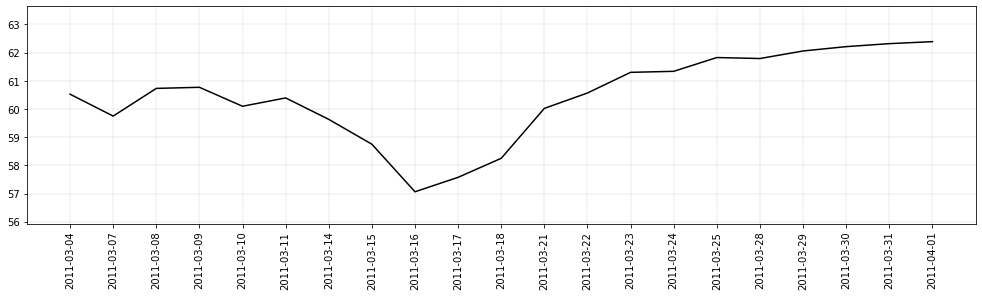

In [36]:
episode_count = 20

for i in range(episode_count):
    run_episode(env)
    


In [21]:
plt_df

,Open,High,Low,Close,Volume,OpenInt,Trades,Pos,Actions
Date,,,,,,,,,
1982-11-24,3.6584,3.6837,3.6079,3.6417,4595400,0,0,0,0
1982-11-26,3.6670,3.6837,3.6417,3.6837,2537518,0,0,0,0
1982-11-29,3.6670,3.7175,3.6079,3.7175,1977010,0,0,0,0
1982-11-30,3.8356,3.9619,3.7006,3.9451,6927130,0,0,0,0
1982-12-01,4.0041,4.0801,3.9282,3.9282,670214,0,0,0,0
1982-12-02,4.0380,4.1136,3.9619,4.0210,3796267,0,0,0,0
1982-12-03,4.0041,4.0549,3.9619,3.9789,2212421,0,0,0,0
1982-12-06,3.9873,4.0972,3.8859,4.0972,2529511,0,0,0,0
1982-12-07,4.1897,4.2654,4.1136,4.1305,5049412,0,0,0,0


In [22]:
plt_df.to_clipboard()

In [23]:
info_log['total_return']

0.8420174643710354